# Build target dataset

In this notebook, we create a dataset containing solar irradiation data. It contains field measurements as well as clearsky data from PVlib. !we deal with missing values, we discard values that exceed physical possible limits. This dataset also contains the target feature of our ML problem : $K_c$.  

This dataset is stored in *ghi_data_5min.csv*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pvlib
from PIL import Image

`datetime_of_images.npy` : contient les instants des images prises par la caméra mobotix1 entre le **2020-05-26 et 2020-10-22**, pour lesquels le GHI clear_sky n'est pas nul.
--------------

In [2]:
time_list = np.load("../../Solais_Data/datetime_of_images.npy")

LOC = {"latitude" : 13.078453 , "longitude" : -11.405649} #coord mobotix1
ALT = 118 #altitude mobotix1

loc = pvlib.location.Location(LOC['latitude'], LOC['longitude'], altitude=ALT)
clearsky = loc.get_clearsky(times=pd.to_datetime(time_list), linke_turbidity=1)
# rename the column
clearsky = clearsky.rename(columns={"ghi": "clearsky_ghi", "dni": "clearsky_dni", "dhi": "clearsky_dhi"})

In [3]:
solarpos = loc.get_solarposition(times=pd.to_datetime(time_list))
clearsky = pd.concat([clearsky, solarpos], axis=1)
clearsky

,clearsky_ghi,clearsky_dni,clearsky_dhi,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2020-05-26 07:01:00,139.728067,872.275873,3.710349,81.029014,81.127653,8.970986,8.872347,70.136645,2.913545
2020-05-26 08:29:00,520.938598,1038.132026,13.833040,60.759349,60.788852,29.240651,29.211148,72.783194,2.906601
2020-05-26 08:30:00,525.029219,1038.768176,13.941662,60.527017,60.556244,29.472983,29.443756,72.799151,2.906521
2020-05-26 08:31:00,529.111138,1039.394378,14.050054,60.294661,60.323617,29.705339,29.676383,72.814757,2.906442
2020-05-26 08:32:00,533.184269,1040.010847,14.158212,60.062282,60.090971,29.937718,29.909029,72.830013,2.906363
...,...,...,...,...,...,...,...,...,...
2020-10-22 18:17:00,6.371781,379.020833,0.169197,89.062327,89.467930,0.937673,0.532070,258.162451,15.642140
2020-10-22 18:18:00,4.547628,348.237469,0.120758,89.271624,89.706371,0.728376,0.293629,258.219152,15.642238
2020-10-22 18:19:00,2.967486,317.169844,0.078799,89.478160,89.944861,0.521840,0.055139,258.275645,15.642335
2020-10-22 18:20:00,1.631903,286.156963,0.043334,89.681927,90.183399,0.318073,-0.183399,258.331932,15.642433


In [4]:
ghi_data = pd.read_csv("../../Solais_Data/GHIs.csv")

ghi_sensor = ghi_data.rename(columns={"Var2_1": "ghi1", "Var2_2": "ghi2", "Var2_3": "ghi3", "Var2_4": "ghi4"})
# Transform the date contained in Var1 to a Datetime object
ghi_sensor["Var1"] = pd.to_datetime(ghi_sensor["Var1"], format='%d-%b-%Y %H:%M:%S')
# Set the datetime as the index
ghi_sensor.set_index("Var1", inplace=True)
ghi_sensor.index.name = None

#### Dealing with missing values :  
We drop rows for which none of the sensors measured a GHI.    
Then we compute the mean of GHI measurements. NaN are taken as zeros by mean function.

In [5]:
ghi_sensor["count_nan"] = ghi_sensor.isnull().sum(axis=1)
previous_len = len(ghi_sensor)
ghi_sensor = ghi_sensor[ghi_sensor.count_nan < 4]
new_len = len(ghi_sensor)
ghi_sensor.drop(columns=["count_nan"], inplace=True)
ghi_sensor["ghi_mean"] = ghi_sensor.mean(1)
print(f"We kept {100*round(new_len/previous_len, 2)} % of the data")

We kept 85.0 % of the data


In [6]:
ghi_sensor

,ghi1,ghi2,ghi3,ghi4,ghi_mean
2020-02-05 08:02:00,77.21,NaN,NaN,NaN,77.2100
2020-02-05 08:03:00,81.67,NaN,NaN,NaN,81.6700
2020-02-05 08:04:00,85.70,NaN,NaN,NaN,85.7000
2020-02-05 08:05:00,91.68,NaN,NaN,NaN,91.6800
2020-02-05 08:06:00,103.67,NaN,NaN,NaN,103.6700
...,...,...,...,...,...
2021-01-20 13:26:00,841.77,828.40,842.33,849.61,840.5275
2021-01-20 13:27:00,843.24,840.97,841.21,846.76,843.0450
2021-01-20 13:28:00,837.87,834.37,834.44,841.29,836.9925
2021-01-20 13:29:00,834.46,832.57,833.66,837.20,834.4725


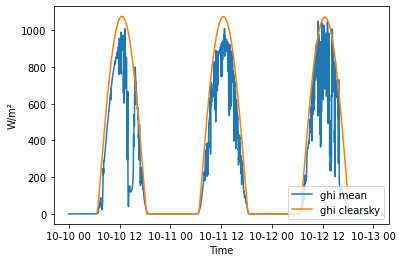

In [40]:
plt.plot(ghi_sensor.loc["2020-10-10":"2020-10-12", "ghi_mean"], label="ghi mean")
plt.plot(clearsky.loc["2020-10-10":"2020-10-12", "clearsky_ghi"], label="ghi clearsky")
plt.ylabel("W/m²")
plt.xlabel("Time")
plt.legend(loc="lower right")

In [12]:
# Merge the datasets based on datetime
data = pd.merge(clearsky, ghi_sensor, left_index=True, right_index=True)
# Get mean GHI / Clearsky GHI ratio
eps = 0.01
data["mean/clearsky"] = data["ghi_mean"]/(data["clearsky_ghi"] + eps)
data 

,clearsky_ghi,clearsky_dni,clearsky_dhi,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,ghi1,ghi2,ghi3,ghi4,ghi_mean,mean/clearsky
2020-05-29 18:23:00,149.606279,882.989473,3.972656,80.506689,80.600349,9.493311,9.399651,290.333807,2.475089,0.00,0.00,0.00,0.00,0.0000,0.000000
2020-05-29 18:24:00,145.263873,878.095365,3.857347,80.732862,80.828619,9.267138,9.171381,290.376624,2.474992,0.00,0.00,0.00,0.00,0.0000,0.000000
2020-05-29 18:25:00,140.930228,873.012279,3.742271,80.958883,81.056825,9.041117,8.943175,290.419760,2.474896,0.00,0.00,0.00,0.00,0.0000,0.000000
2020-05-29 18:26:00,136.606127,867.729821,3.627449,81.184745,81.284966,8.815255,8.715034,290.463216,2.474800,0.00,0.00,0.00,0.00,0.0000,0.000000
2020-05-29 18:27:00,132.292414,862.236878,3.512902,81.410442,81.513043,8.589558,8.486957,290.506992,2.474704,0.00,0.00,0.00,0.00,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-22 18:17:00,6.371781,379.020833,0.169197,89.062327,89.467930,0.937673,0.532070,258.162451,15.642140,8.77,9.21,8.64,8.31,8.7325,1.368348
2020-10-22 18:18:00,4.547628,348.237469,0.120758,89.271624,89.706371,0.728376,0.293629,258.219152,15.642238,7.90,8.22,7.70,7.37,7.7975,1.710868
2020-10-22 18:19:00,2.967486,317.169844,0.078799,89.478160,89.944861,0.521840,0.055139,258.275645,15.642335,7.11,7.36,6.90,6.62,6.9975,2.350137
2020-10-22 18:20:00,1.631903,286.156963,0.043334,89.681927,90.183399,0.318073,-0.183399,258.331932,15.642433,6.39,6.60,6.05,5.86,6.2250,3.791332


In [13]:
f"dataset contains {data.shape[0]} GHI measurements"  

'dataset contains 104988 GHI measurements'

In [14]:
data_desc = data.describe().round()
data_desc

,clearsky_ghi,clearsky_dni,clearsky_dhi,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,ghi1,ghi2,ghi3,ghi4,ghi_mean,mean/clearsky
count,104988.0,104988.0,104988.0,104988.0,104988.0,104988.0,104988.0,104988.0,104988.0,104988.0,104988.0,104988.0,104988.0,104988.0,104988.0
mean,684.0,1017.0,18.0,47.0,47.0,43.0,43.0,179.0,1.0,396.0,384.0,398.0,360.0,384.0,1.0
std,348.0,137.0,9.0,24.0,24.0,24.0,24.0,98.0,7.0,306.0,316.0,313.0,319.0,294.0,2.0
min,0.0,228.0,0.0,0.0,0.0,0.0,-1.0,0.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,392.0,1016.0,10.0,25.0,25.0,22.0,22.0,79.0,-5.0,121.0,96.0,118.0,62.0,117.0,0.0
50%,760.0,1068.0,20.0,46.0,46.0,44.0,44.0,173.0,-1.0,346.0,328.0,343.0,294.0,347.0,1.0
75%,1010.0,1082.0,27.0,68.0,68.0,65.0,65.0,280.0,5.0,638.0,629.0,643.0,593.0,618.0,1.0
max,1120.0,1122.0,30.0,90.0,91.0,90.0,90.0,360.0,16.0,1376.0,1416.0,1425.0,1494.0,1307.0,428.0


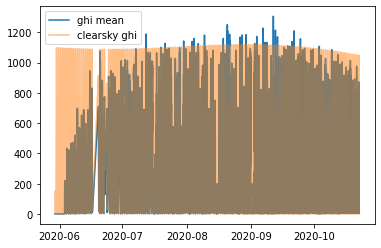

In [15]:
plt.plot(data["ghi_mean"], label="ghi mean")
plt.plot(data["clearsky_ghi"], alpha=0.5, label="clearsky ghi")
plt.legend()

In [16]:
under_clearsky = np.count_nonzero(data["mean/clearsky"] <= 1.)/len(data["mean/clearsky"])
f"the mean GHI is {100*round(under_clearsky, 2)}% of the time UNDER clearsky GHI"

'the mean GHI is 99.0% of the time UNDER clearsky GHI'

<AxesSubplot:ylabel='Frequency'>

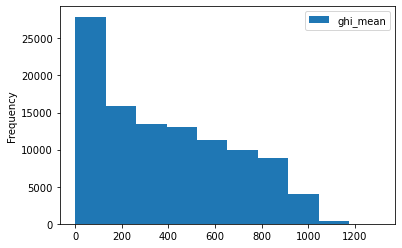

In [17]:
data["ghi_mean"].plot.hist(legend=True)

We have got a lot of mean_GHI = 0.

### Let's implement rules to delete outliers

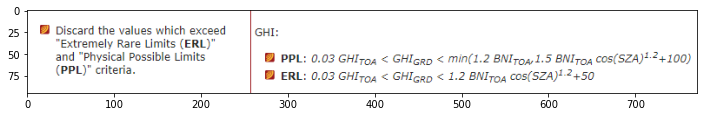

In [18]:
rules = np.array(Image.open("../../Solais_Data/delete_GHI_outliers.png"))
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(111)
ax1.imshow(rules)

TOA : Top of Atmosphere, BNI = DNI (Direct Normal Irradiance)  

We can try to use TOA and Extraterrestrial data from SoDa stream.

In [19]:
# Charge SoDa Stream data for mobotix 1 position
TOA = pd.read_csv("../../Solais_Data/SoDa_E0-and-ToA.csv", header=14, sep=';')
TOA = TOA[["Year", "Month", "Day", "Extraterrestrial Irradiance", "Irradiance (W/m2)"]]

In [20]:
TOA.describe().round()

,Year,Month,Day,Extraterrestrial Irradiance,Irradiance (W/m2)
count,147.0,147.0,147.0,147.0,147.0
mean,2020.0,8.0,15.0,1339.0,430.0
std,0.0,1.0,9.0,19.0,13.0
min,2020.0,5.0,1.0,1321.0,390.0
25%,2020.0,7.0,8.0,1324.0,426.0
50%,2020.0,8.0,15.0,1330.0,437.0
75%,2020.0,9.0,22.0,1354.0,438.0
max,2020.0,10.0,31.0,1382.0,440.0


Daily data :  
* Irradiance : Mean irradiance for that day at the top of atmosphere (ToA) on horizontal plane. Would have been useful to have this irradiance every minutes.  
* Extraterrestrial Irradiance : Irradiance (E0) falling on an area perpendicular to the solar rays outside the atmosphere. Is *always greater* than ghi_mean.  

Why not use the clearsky data instead ? We replace ToA GHI with clearsky GHI

In [21]:
data["ghi_clipped"] = data["ghi_mean"].clip(upper=1.2*data["clearsky_ghi"])
data["Kc"] = data["ghi_clipped"]/(data["clearsky_ghi"] + eps)

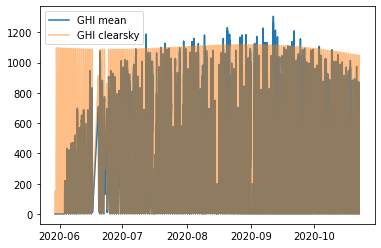

In [22]:
plt.plot(data["ghi_clipped"], label="GHI mean")
plt.plot(data["clearsky_ghi"], alpha=0.5, label="GHI clearsky")
plt.legend()

<AxesSubplot:ylabel='Frequency'>

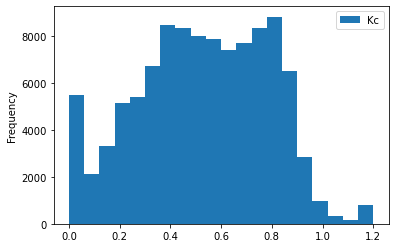

In [27]:
data["Kc"].plot.hist(legend=True, bins=20)

In [24]:
under_clearsky = np.count_nonzero(data["Kc"] <= 1.)/len(data["Kc"])
f"the mean GHI is {100*round(under_clearsky, 2)}% of the time UNDER clearsky GHI"

'the mean GHI is 99.0% of the time UNDER clearsky GHI'

"Too many" small GHI values. We drop rows where GHI clearsky is below 20 W/m². Plus, GHI sensors are less precise when irradiance is low.

In [28]:
prev_shape = len(data)
data = data[data.clearsky_ghi>20]
print(f"we lost {prev_shape - len(data)} rows")

we lost 2202 rows


Summary of operations made to obtain ghi_target :  
1. Moments where the 4 GHI sensors have missing values are discarded. Then the mean of GHI values of sensors 1 to 4 is computed.  

2. Delete outliers thanks to SoDa *quality check procedure* (http://www.soda-pro.com/help/general/quality-check). 
GHI values are clipped between 0.03 x Clearsky_GHI and 1.2 x min(Clearsky_GHI, Clearsky_DNI).  

3. We discard values below 20 W/m². "Most instruments present a high uncertainty in low radiation conditions" (Source : SoDa *quality check procedure*)  

Let's downsample the time series to 5 minutes intervals.


-----------
### Let's extract the target data

In [94]:
data

,clearsky_ghi,clearsky_dni,clearsky_dhi,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,ghi1,ghi2,ghi3,ghi4,ghi_mean,mean/clearsky,ghi_clipped,Kc
2020-05-29 18:23:00,149.606279,882.989473,3.972656,80.506689,80.600349,9.493311,9.399651,290.333807,2.475089,0.00,0.00,0.00,0.00,0.0000,0.000000,0.0000,0.000000
2020-05-29 18:24:00,145.263873,878.095365,3.857347,80.732862,80.828619,9.267138,9.171381,290.376624,2.474992,0.00,0.00,0.00,0.00,0.0000,0.000000,0.0000,0.000000
2020-05-29 18:25:00,140.930228,873.012279,3.742271,80.958883,81.056825,9.041117,8.943175,290.419760,2.474896,0.00,0.00,0.00,0.00,0.0000,0.000000,0.0000,0.000000
2020-05-29 18:26:00,136.606127,867.729821,3.627449,81.184745,81.284966,8.815255,8.715034,290.463216,2.474800,0.00,0.00,0.00,0.00,0.0000,0.000000,0.0000,0.000000
2020-05-29 18:27:00,132.292414,862.236878,3.512902,81.410442,81.513043,8.589558,8.486957,290.506992,2.474704,0.00,0.00,0.00,0.00,0.0000,0.000000,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-22 18:07:00,35.645277,633.216706,0.946527,86.858756,87.086301,3.141244,2.913699,257.583551,15.641165,19.14,20.09,20.25,18.69,19.5425,0.548096,19.5425,0.548096
2020-10-22 18:08:00,32.022039,613.031255,0.850315,87.085338,87.324229,2.914662,2.675771,257.642444,15.641263,17.98,18.81,18.87,17.60,18.3150,0.571771,18.3150,0.571771
2020-10-22 18:09:00,28.517465,591.706036,0.757255,87.310950,87.562211,2.689050,2.437789,257.701108,15.641360,16.94,17.70,17.66,16.49,17.1975,0.602840,17.1975,0.602840
2020-10-22 18:10:00,25.143819,569.200257,0.667671,87.535467,87.800246,2.464533,2.199754,257.759546,15.641458,15.79,16.43,16.34,15.41,15.9925,0.635788,15.9925,0.635788


In [29]:
data_5min = data.resample(rule="5T", origin="start").first()

In [30]:
data_5min

,clearsky_ghi,clearsky_dni,clearsky_dhi,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,ghi1,ghi2,ghi3,ghi4,ghi_mean,mean/clearsky,ghi_clipped,Kc
2020-05-29 18:23:00,149.606279,882.989473,3.972656,80.506689,80.600349,9.493311,9.399651,290.333807,2.475089,0.00,0.00,0.00,0.00,0.0000,0.000000,0.0000,0.000000
2020-05-29 18:28:00,127.989996,856.521562,3.398655,81.635966,81.741054,8.364034,8.258946,290.551088,2.474608,0.00,0.00,0.00,0.00,0.0000,0.000000,0.0000,0.000000
2020-05-29 18:33:00,106.684617,824.131003,2.832911,82.760707,82.880103,7.239293,7.119897,290.776411,2.474127,0.00,0.00,0.00,0.00,0.0000,0.000000,0.0000,0.000000
2020-05-29 18:38:00,85.849730,783.832111,2.279660,83.879645,84.017418,6.120355,5.982582,291.009877,2.473646,0.00,0.00,0.00,0.00,0.0000,0.000000,0.0000,0.000000
2020-05-29 18:43:00,65.731622,732.815503,1.745442,84.990809,85.152918,5.009191,4.847082,291.251601,2.473164,0.00,0.00,0.00,0.00,0.0000,0.000000,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-22 17:48:00,116.746204,866.217222,3.100087,82.461164,82.576404,7.538836,7.423596,256.418265,15.639310,51.23,54.20,55.78,51.91,53.2800,0.456335,53.2800,0.456335
2020-10-22 17:53:00,94.052974,824.943216,2.497489,83.627959,83.761150,6.372041,6.238850,256.733853,15.639799,41.60,42.31,44.52,38.58,41.7525,0.443878,41.7525,0.443878
2020-10-22 17:58:00,72.031558,772.219692,1.912731,84.790273,84.947413,5.209727,5.052587,257.042884,15.640287,29.49,31.05,34.82,32.30,31.9150,0.443008,31.9150,0.443008
2020-10-22 18:03:00,51.113559,703.580024,1.357273,85.944730,86.135126,4.055270,3.864874,257.345653,15.640775,23.83,25.01,26.47,24.10,24.8525,0.486126,24.8525,0.486126


This creates artificial datetimes. Indeed, we should now have only len(target)/5 values, that is to say approximately 20000 rows.

In [31]:
common_dates = data.index.intersection(other=data_5min.index, sort=None)
f"data and 5min data have {len(common_dates)} values in common"

'data and 5min data have 20559 values in common'

In [32]:
data_5min = pd.merge(data_5min, data, left_index=True, right_index=True)

It seems that the PV installation was not completed before mid-June 2020. To have relevant GHI targets, we should keep GHI data corresponding to a stationnary PV installation.

In [33]:
data_5min = data_5min.loc["2020-06-20":, 'clearsky_ghi_x' : 'Kc_x']
data_5min.rename(columns=(lambda x: x[0:-2]), inplace=True)
data_5min

,clearsky_ghi,clearsky_dni,clearsky_dhi,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,ghi1,ghi2,ghi3,ghi4,ghi_mean,mean/clearsky,ghi_clipped,Kc
2020-06-20 06:33:00,21.083358,523.008808,0.559849,87.751066,88.030116,2.248934,1.969884,66.387850,-1.636136,13.07,13.96,13.27,13.17,13.3675,0.633730,13.3675,0.633730
2020-06-20 06:38:00,36.708368,619.571102,0.974757,86.693645,86.913528,3.306355,3.086472,66.649220,-1.636898,18.48,19.58,18.77,18.76,18.8975,0.514661,18.8975,0.514661
2020-06-20 06:43:00,54.526772,694.243703,1.447908,85.615134,85.794776,4.384866,4.205224,66.901419,-1.637659,24.58,26.15,25.24,25.15,25.2800,0.463540,25.2800,0.463540
2020-06-20 06:48:00,73.739770,752.065994,1.958091,84.523011,84.673958,5.476989,5.326042,67.144588,-1.638421,31.07,32.86,31.84,31.75,31.8800,0.432273,31.8800,0.432273
2020-06-20 06:53:00,93.849565,797.436717,2.492088,83.421527,83.551169,6.578473,6.448831,67.378853,-1.639183,39.53,42.12,41.18,41.13,40.9900,0.436716,40.9900,0.436716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-22 17:48:00,116.746204,866.217222,3.100087,82.461164,82.576404,7.538836,7.423596,256.418265,15.639310,51.23,54.20,55.78,51.91,53.2800,0.456335,53.2800,0.456335
2020-10-22 17:53:00,94.052974,824.943216,2.497489,83.627959,83.761150,6.372041,6.238850,256.733853,15.639799,41.60,42.31,44.52,38.58,41.7525,0.443878,41.7525,0.443878
2020-10-22 17:58:00,72.031558,772.219692,1.912731,84.790273,84.947413,5.209727,5.052587,257.042884,15.640287,29.49,31.05,34.82,32.30,31.9150,0.443008,31.9150,0.443008
2020-10-22 18:03:00,51.113559,703.580024,1.357273,85.944730,86.135126,4.055270,3.864874,257.345653,15.640775,23.83,25.01,26.47,24.10,24.8525,0.486126,24.8525,0.486126


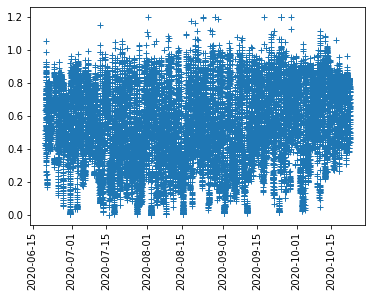

In [34]:
plt.xticks(rotation=90)
plt.plot(data_5min.Kc, "+")

<AxesSubplot:ylabel='Frequency'>

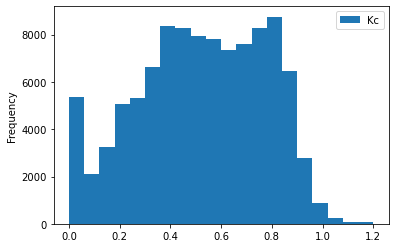

In [35]:
data["Kc"].plot.hist(legend=True, bins=20)

In [262]:
data_5min.to_csv("../../processed_data/ghi_data_5min.csv")